In [1]:
# refresh
%load_ext autoreload
%autoreload 2

In [5]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
import yaml

# PCA
from sklearn.decomposition import PCA, IncrementalPCA


%matplotlib inline

In [53]:
import io
from PIL import Image

def fig2img(fig):
    """
    Convert a Matplotlib figure to a PIL Image and return it
    https://stackoverflow.com/a/61754995
    """
    buf = io.BytesIO()
    _ = fig.savefig(buf)
    _ = buf.seek(0)
    img = Image.open(buf)
    img = img.convert('RGB')
    return img

In [6]:
# load data
CONFIG_FILE = '../experiments/train_mnist.yaml'
RUN_NAME = 'mnist_mlp_20230611-180914'


# 'mnist_mlp_20230607-054432'

# load config
with open(CONFIG_FILE) as f:
    config = yaml.safe_load(f)

# get data
save_dir = config["save_dir"]

# save_dir actually starts with ../
save_dir = '../' + save_dir

model_params = config["model"]
dataset_params = config["data"]
training_params = config["training"]
logging_params = config["logging"]

# get saving directories
save_dir = pathlib.Path(save_dir)

run_dir = save_dir / RUN_NAME

model_save_dir = run_dir / model_params["model_save_dir"]
model_save_path = model_save_dir / (RUN_NAME + ".ckpt")

activations_save_dir = run_dir / model_params["activations_save_dir"]
activations_save_path = activations_save_dir / ("activations" + ".h5")

gradients_save_dir = run_dir / model_params["gradients_save_dir"]
gradients_save_path = gradients_save_dir / ("gradients" + ".h5")

weight_gradients_save_dir = run_dir / model_params["weights_save_dir"]
weight_gradients_save_path = weight_gradients_save_dir / ("weight_gradients" + ".h5")

weights_save_dir = run_dir / model_params["weights_save_dir"]
weights_save_path = weights_save_dir / ("weights" + ".h5")

logger_csv = model_save_dir / 'lightning_logs' / 'version_0' / 'metrics.csv'

In [7]:
# load data
df = pd.read_csv(logger_csv)

# select rows where train_loss_step is not nan
train_step_df = df[df['train_loss_step'].notna()]
valid_step_df = df[df['val_loss_step'].notna()]

# select rows where train_loss_epoch is not nan
train_epoch_df = df[df['train_loss_epoch'].notna()]
valid_epoch_df = df[df['val_loss_epoch'].notna()]

max_step = max(train_step_df['step']) + 1
max_epoch = int(max(train_epoch_df['epoch'])) + 1
max_step, max_epoch

(46900, 100)

### Plotting weight space

In [16]:
# load the weight matrices as an .h5 file
import h5py

split = 'train'
layer_names = ['fc_layers.{i}.weight'.format(i=i) for i in range(3)]
# layer_names = layer_names[0:1]

num_batches_per_epoch = 469
n = 10

weight_dict = {layer_name: [] for layer_name in layer_names}
incremental_pca_dict = {layer_name: IncrementalPCA(n_components=n) for layer_name in layer_names}

with h5py.File(weights_save_path, 'r') as f:
    for epoch_num in range(max_epoch):
        # epoch_group = f'epoch_{epoch_num:03d}'
        for trainer_steps in range(epoch_num*num_batches_per_epoch + 1, (epoch_num+1)*num_batches_per_epoch + 1):
            # print(trainer_steps)
            batch_name = f'batch_{trainer_steps:07d}'

            for layer_name in layer_names:
                # get the weights for this layer
                weights = np.array(f[batch_name][split][layer_name])

                # append to the list
                weight_dict[layer_name].append(weights)


        # convert to numpy arrays
        for layer_name in layer_names:
            weight_dict[layer_name] = np.array(weight_dict[layer_name])
            # reshape to (num_batches_per_epoch, -1)
            weight_dict[layer_name] = weight_dict[layer_name].reshape(num_batches_per_epoch, -1)

        # fit incremental PCA
        for layer_name in layer_names:
            incremental_pca_dict[layer_name].partial_fit(weight_dict[layer_name])
            # print(weight_dict[layer_name].shape, incremental_pca_dict[layer_name].explained_variance_ratio_.sum())


        # reset weight_dict
        weight_dict = {layer_name: [] for layer_name in layer_names}




print('done')

done


### Weights have been obtained. Now let's analyze them

In [17]:
# save each PCA object
import pickle
import pathlib

for layer_name in layer_names:
    # use the model_save_dir
    pca_save_dir = model_save_dir / 'pca'
    pca_save_dir.mkdir(parents=True, exist_ok=True)

    pca_save_path = pca_save_dir / (layer_name + '.pkl')

    with open(pca_save_path, 'wb') as f:
        pickle.dump(incremental_pca_dict[layer_name], f)

print('done')


done


In [19]:
# transform the original dataset into the PCA space

pca_weights_save_path = weights_save_dir / ("weights_pca" + ".h5")

num_batches_per_epoch = 469
n = 10

# using the incremental PCA object, transform the weights

weight_dict = {layer_name: [] for layer_name in layer_names}

with h5py.File(pca_weights_save_path, 'a') as new_f:
    with h5py.File(weights_save_path, 'r') as f:
        for epoch_num in range(max_epoch):
            epoch_group = f'epoch_{epoch_num:03d}'
            for trainer_steps in range(epoch_num*num_batches_per_epoch + 1, (epoch_num+1)*num_batches_per_epoch + 1):
                # print(trainer_steps)
                batch_name = f'batch_{trainer_steps:07d}'

                for layer_name in layer_names:
                    # get the weights for this layer
                    weights = np.array(f[batch_name][split][layer_name])

                    # append to the list
                    weight_dict[layer_name].append(weights)


            # convert to numpy arrays
            for layer_name in layer_names:
                weight_dict[layer_name] = np.array(weight_dict[layer_name])
                # reshape to (num_batches_per_epoch, -1)
                weight_dict[layer_name] = weight_dict[layer_name].reshape(num_batches_per_epoch, -1)

            # fit incremental PCA
            for layer_name in layer_names:
                # transform the weights
                transformed_weights = incremental_pca_dict[layer_name].transform(weight_dict[layer_name])

                # save the transformed weights using f.create_dataset
                new_f.create_dataset(f'{epoch_group}/train/{layer_name}', data=transformed_weights)


            # reset weight_dict
            weight_dict = {layer_name: [] for layer_name in layer_names}

print('done, saved to', pca_weights_save_path)

done


In [23]:
split = 'train'
layer_names = ['fc_layers.{i}.weight'.format(i=i) for i in range(3)]

weight_dict = {layer_name: [] for layer_name in layer_names}

with h5py.File(pca_weights_save_path, 'r') as f:
    for epoch_num in range(max_epoch):
        epoch_group = f'epoch_{epoch_num:03d}'
        # print(epoch_group)
        for layer_name in layer_names:
            # get the weights for this layer
            weights = np.array(f[epoch_group][split][layer_name])

            # append to the list
            weight_dict[layer_name].append(weights)

# convert to numpy arrays
for layer_name in layer_names:
    weight_dict[layer_name] = np.array(weight_dict[layer_name])
    # reshape to (epoch, row * col)

    # print(weight_dict[layer_name].shape)
    weight_dict[layer_name] = weight_dict[layer_name].reshape(max_epoch * num_batches_per_epoch, -1)
    print(weight_dict[layer_name].shape)

print('done loading transformed weights')

(46900, 10)
(46900, 10)
(46900, 10)
done loading transformed weights


#### doing things with the transformed weights (post PCA)

In [45]:
# import numpy as np
# from scipy.signal import cwt, morlet2
#
# # Assuming your PCA features are stored in a numpy array called "features"
# # with shape (469000, 10)
#
# # Define the scales for the wavelet transform
# scales = np.arange(1, 11)
# features = weight_dict['fc_layers.0.weight']
#
# # Initialize an array to store the wavelet transform amplitudes
# wavelet_amplitudes = np.zeros((features.shape[0], features.shape[1], len(scales)))
#
# # Compute the wavelet transform for each feature dimension
# for i in range(features.shape[1]):
#     feature = features[:, i]
#     wavelet_amplitudes[:, i, :] = cwt(feature, morlet2, scales)
#
# # Now wavelet_amplitudes has shape (469000, 10, len(scales)), where each
# # wavelet_amplitudes[:, i, :] represents the wavelet transform amplitudes
# # for the i-th feature dimension.
#


#### tSNE

In [46]:
# tsne
from sklearn.manifold import TSNE

tsne_dict = {layer_name: [] for layer_name in layer_names}

n_jobs = 8

for layer_name in layer_names:
    tsne = TSNE(n_components=2, n_jobs=n_jobs)
    tsne.fit(weight_dict[layer_name])
    tsne_dict[layer_name] = tsne

print('done')

done


In [47]:
# fit tsne, but grab random 20% of the data

tsne_dict_20 = {layer_name: [] for layer_name in layer_names}

n_jobs = 8

for layer_name in layer_names:
    tsne = TSNE(n_components=2, n_jobs=n_jobs)

    # randomly sample 20% of the data
    idx = np.random.choice(weight_dict[layer_name].shape[0], size=int(weight_dict[layer_name].shape[0] * 0.2), replace=False)
    tsne.fit(weight_dict[layer_name][idx])
    tsne_dict_20[layer_name] = tsne

print('done')

done


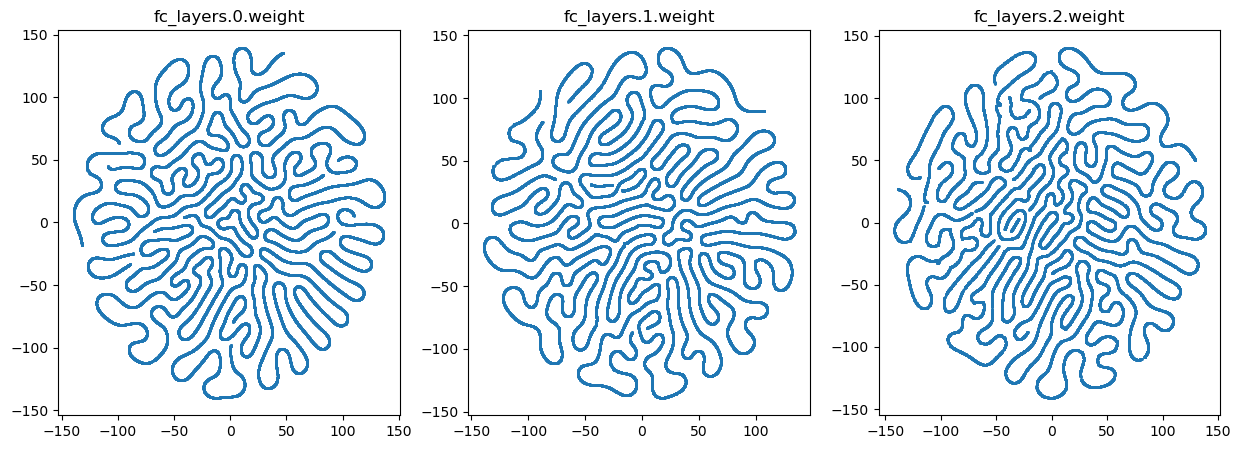

In [48]:
# plot tsne
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, layer_name in enumerate(layer_names):
    ax[i].scatter(tsne_dict[layer_name].embedding_[:, 0], tsne_dict[layer_name].embedding_[:, 1], s=1)
    ax[i].set_title(layer_name)

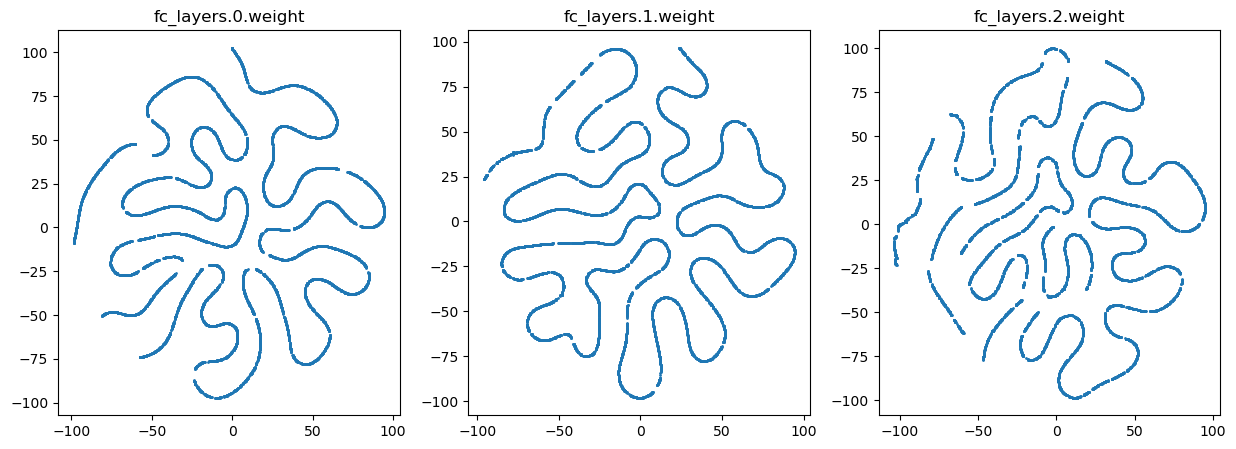

In [50]:
# plot tsne for 20% of the data
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# plot tsne
for i, layer_name in enumerate(layer_names):
    ax[i].scatter(tsne_dict_20[layer_name].embedding_[:, 0], tsne_dict_20[layer_name].embedding_[:, 1], s=1)
    ax[i].set_title(layer_name)

In [51]:
# mess with perplexity
tsne_dict_perplexity = {layer_name: [] for layer_name in layer_names}

n_jobs = 8

for layer_name in layer_names:
    tsne = TSNE(n_components=2, n_jobs=n_jobs, perplexity=100)

    tsne.fit(weight_dict[layer_name])
    tsne_dict_perplexity[layer_name] = tsne

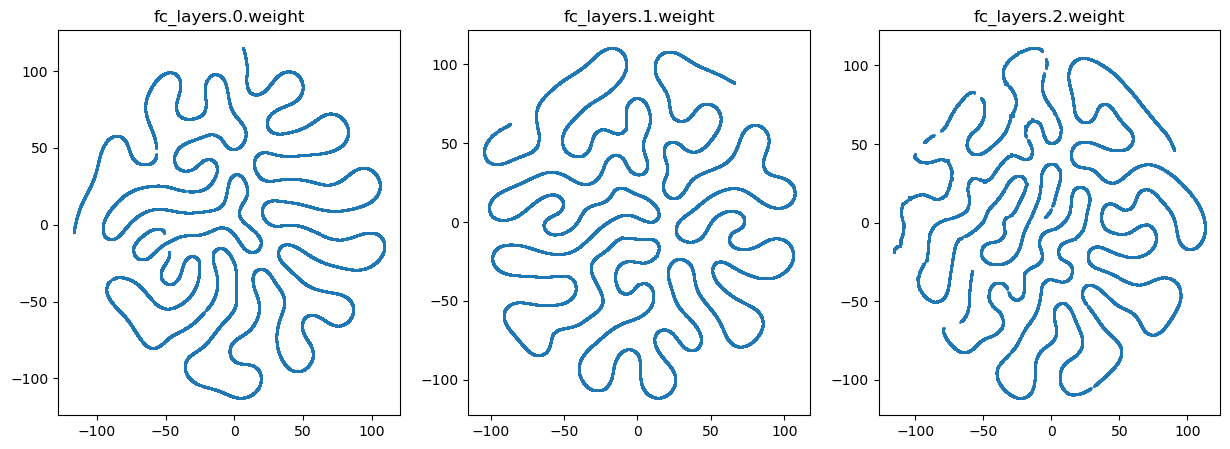

In [52]:
# plot tsne
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, layer_name in enumerate(layer_names):
    ax[i].scatter(tsne_dict_perplexity[layer_name].embedding_[:, 0], tsne_dict_perplexity[layer_name].embedding_[:, 1], s=1)
    ax[i].set_title(layer_name)

(235,)
(235, 10)
(235,)
(235, 10)
(235,)
(235, 10)


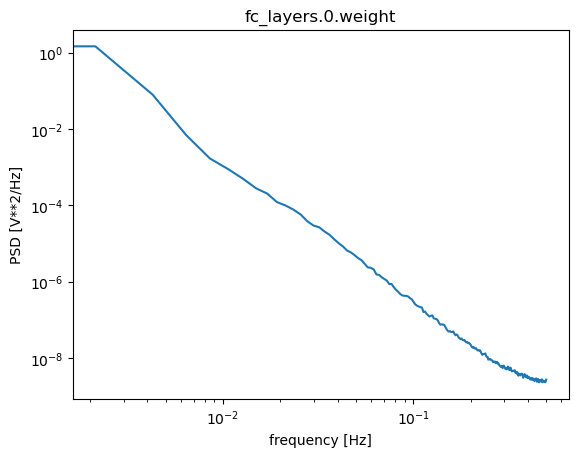

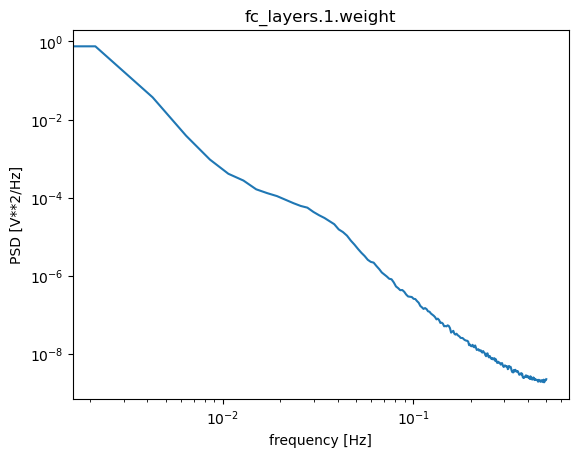

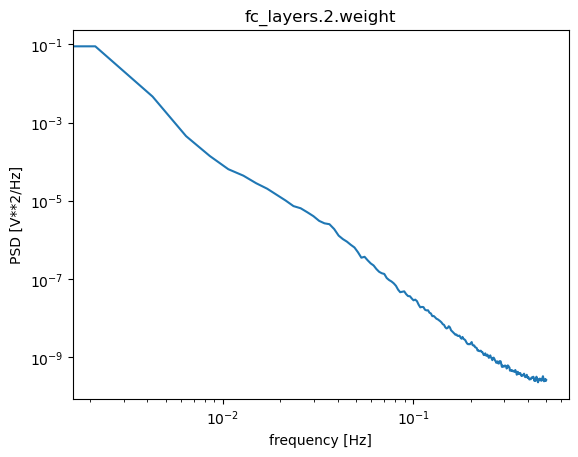

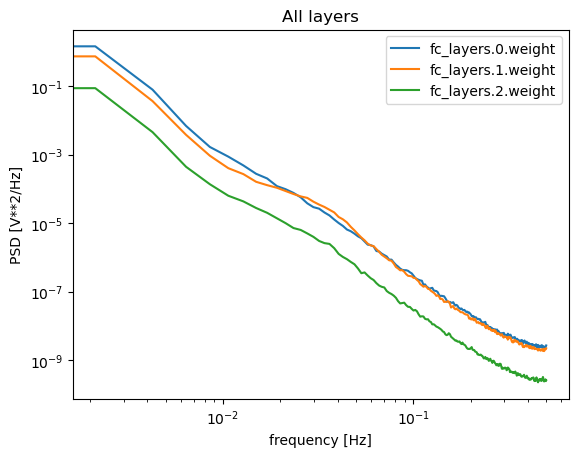

In [60]:
# PSD on the axes of variance

import os
import scipy
# get the power spectral density of the pca of the activations
os.makedirs('psd', exist_ok=True)

k = 10
psd_trajectory_dict = {}
for name, activations in weight_dict.items():
    # get the pca of the activations to k dimensions
    pca_variance_ratio = incremental_pca_dict[name].explained_variance_ratio_
    activations_pca = activations

    # activations_reshaped = activations_pca.reshape(num_episodes_to_run, num_steps_per_episode,
    #                                                -1)  # (episodes, steps, k)
    f, psd = scipy.signal.welch(activations_pca, fs=1, nperseg=469, noverlap=234, axis=-2)

    print(f.shape)
    print(psd.shape)

    psd_pca = np.average(psd, axis=-1, weights=pca_variance_ratio)  # (episodes, steps)
    psd_trajectory = psd_pca
    # psd_trajectory = np.mean(psd_pca, axis=0)  # (steps,)

    psd_trajectory_dict[name] = psd_trajectory

    # make a plot of the power spectral density
    fig, ax = plt.subplots()
    ax.semilogy(f, psd_trajectory)
    ax.set_title(name)
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('PSD [V**2/Hz]')
    # set x scale to log
    ax.set_xscale('log')

    save_path = 'psd/{}.png'.format(name)
    # save_path = None
    fig_im = fig2img(fig)
    if save_path is not None:
        fig_im.save(save_path)

# make a plot of the power spectral density of all the layers from psd_trajectory_dict
fig, ax = plt.subplots()
for name, psd_trajectory in psd_trajectory_dict.items():
    ax.semilogy(f, psd_trajectory, label=name)
ax.set_title('All layers')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
# set x scale to log
ax.set_xscale('log')
ax.legend()

save_path = 'psd/all_layers.png'
# save_path = None
fig_im = fig2img(fig)
if save_path is not None:
    fig_im.save(save_path)
